## DDIM

In [2]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from fastprogress.fastprogress import progress_bar
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler


import miniai.fastprogressfix
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.fid import *

/home/joey/mambaforge/envs/fastai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
def_device

'cuda'

DDPM Scheduler from the diffusers library

In [10]:
# provide new unet to load model
# The last version had an overriden forward to call sample.
# Since we are now using the hugging face library we dont need to unwrap the sample 
class UNet(UNet2DModel): pass

model = torch.load('models/fashion_ddpm2.pkl').cuda()

In [11]:
sched = DDPMScheduler(beta_end=0.01)

This is the steps required in the loop

In [12]:
x_t = torch.randn((32,1,32,32)).cuda() # create sample data (noise)

t = 999 # timestep
t_batch = torch.full((len(x_t),), t, device=x_t.device, dtype=torch.long) # tensor full of timestep 999
with torch.no_grad(): noise = model(x_t, t_batch).sample # pass noise and timestep into model, returns predicted noise
res = sched.step(noise, t, x_t) # use the scheduler to remove predicted noise and add noise back depending on timestep
res.prev_sample.shape

torch.Size([32, 1, 32, 32])

In [13]:
t_batch

tensor([999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999,
        999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999,
        999, 999, 999, 999], device='cuda:0')

Now run above step in a loop working through timesteps

In [14]:
%%time
sz = (2048,1,32,32)
x_t = torch.randn(sz).cuda()
preds = []

for t in progress_bar(sched.timesteps):
    with torch.no_grad(): noise = model(x_t, t).sample
    x_t = sched.step(noise, t, x_t).prev_sample
    preds.append(x_t.float().cpu())


CPU times: user 13min 39s, sys: 2.26 s, total: 13min 41s
Wall time: 13min 41s


In [15]:
s1 = preds[-1]
s = s1.clamp(-0.5,0.5)*2
s1.min(), s1.max(), s1.mean(), s1.std(), "S2", s.min(), s.max(), s.mean(), s.std()


(tensor(-1.),
 tensor(1.),
 tensor(-0.4536),
 tensor(0.5691),
 'S2',
 tensor(-1.),
 tensor(1.),
 tensor(-0.4558),
 tensor(0.7233))

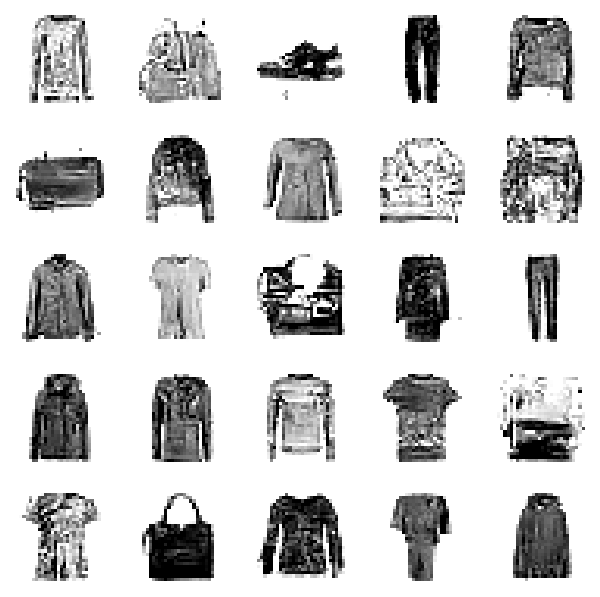

In [16]:
show_images(s[:25], imsize=1.5)


In [17]:
cmodel = torch.load('models/data_aug3.pkl')
del(cmodel[8])
del(cmodel[7])


In [18]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])


(7656.546875, 3209.945556640625)

In [19]:
ie.fid(s),ie.kid(s)

(361.4208984375, 4.767054080963135)

(-7.7542724609375, 1.077541470527649)


In [20]:
ie.fid(xb),ie.kid(xb)


(-0.7451171875, 0.08526536822319031)

In [4]:
clean_mem()